# Inteligent systems seminar 1

## Tree implementation

The `Node` class is implemented by `BinaryOperator`, `UnaryOperator`, `Number` (constant) and `X` (variable).

Crossover is done by getting random subtrees from the parents and switching them. 

Mutation is done by chosing a node and replacing it with a node of the same arity. In the case of a constant, it is randomly slightly increased or decreased.

The fitness function evaluates the tree at each given x value and returns the residual sum of squares, which is the sum of the squares of the differences between the expected and the calculated values. It is negated because pycharm tries to increase the fitness value and we are trying to decrease the error. 

As unwanted values (complex numbers, infinities and NaNs) and computation errors (division by zero, etc.) are hard to predict even given syntactically correct trees, we simply return negative infinity as the fitness for trees that produce them when evaluated. This means that even if such trees appear, they will almost certainly not be selected for the next generation. 

Fitness is also penalized by some small factor multiplied by the size of the tree to prioritize simple equations. The penalty is applied relatively as a multiplication factor for the fitness and also directly, in order to accomodate a large range of possible fitness values. If it were only applied directly, it would be insignificant for trees which return a large fitness value and if it were only applied relatively, then it would be insignificant for trees with a very small fitness value.

# Initial (suboptimal implementation)

In [ ]:
"""
def OLD_P(p):
    return random.rand() < p

def OLD_get_random_subtree(t):
    P_RAND = 0.1
    if isinstance(t, BinaryOperator):
        if P(P_RAND):
            return t
        if P(0.5):
            return get_random_subtree(t.left_child)
        return get_random_subtree(t.right_child)
    elif isinstance(t, Number) or isinstance(t, X):
        return t
    raise NotImplementedError()

def OLD_insert_random_subtree(t, s):
    R_INS = 0.1
    if isinstance(t, BinaryOperator):
        if P(R_INS):
            return s
        if P(0.5):
            return insert_random_subtree(t.left_child, s)
        return insert_random_subtree(t.right_child, s)
    elif isinstance(t, Number) or isinstance(s, X):
        return s
    raise NotImplementedError()


def OLD_crossover_tree(t1, t2):
    s1 = get_random_subtree(t1)
    s2 = get_random_subtree(t2)
    return insert_random_subtree(t1, s2), insert_random_subtree(t2, s1)
"""

In [30]:
from abc import ABC, abstractmethod # abstract classes
import numpy as np # for fitness function
import random

# treat warnings as errors
import warnings
warnings.filterwarnings("error")


# base class
class Node(ABC):
    INT_ARRAY_SIZE = 1000
    P_GENERATION_X = 0.1
    P_ENDTREE_INIT = 0.3
    LONG_EQUATION_PENALTY = 0.0001
    ENABLE_EXTRA_OPERATORS = True

    @abstractmethod
    def evaluate(self, x):
        pass

    @abstractmethod
    def __str__(self):
        pass

    @abstractmethod
    def number_of_nodes(self):
        pass
    
    @abstractmethod
    def list_of_nodes(self):
        pass


# implementations of Node
class BinaryOperator(Node):
    def __init__(self, operator, left_child, right_child):
        self.parent = None
        self.operator = operator
        self.right_child = right_child
        self.left_child = left_child
        left_child.parent = self
        right_child.parent = self

    def evaluate(self, x):
        match(self.operator):
            case '+':
                return self.left_child.evaluate(x) + self.right_child.evaluate(x)
            case '-':
                return self.left_child.evaluate(x) - self.right_child.evaluate(x)
            case '*':
                return self.left_child.evaluate(x) * self.right_child.evaluate(x)
            case '/':
                return self.left_child.evaluate(x) / self.right_child.evaluate(x)
            case '^':
                return self.left_child.evaluate(x) ** self.right_child.evaluate(x)
            case 'max':
                return np.maximum(self.left_child.evaluate(x), self.right_child.evaluate(x))
            case 'min':
                return np.minimum(self.left_child.evaluate(x), self.right_child.evaluate(x))
            case _: # default case
                raise NotImplementedError()
            
    def __str__(self):
        return f"{self.operator} {self.left_child} {self.right_child}"
    
    def number_of_nodes(self):
        return 1 + self.left_child.number_of_nodes() + self.right_child.number_of_nodes()
    
    def list_of_nodes(self):
        return [self] + self.left_child.list_of_nodes() + self.right_child.list_of_nodes()


class UnaryOperator(Node):
    def __init__(self, operator, child):
        self.parent = None
        self.operator = operator
        self.child = child
        child.parent = self

    def evaluate(self, x):
        match(self.operator):
            case 'sin':
                return np.sin(self.child.evaluate(x))
            case 'cos':
                return np.cos(self.child.evaluate(x))
            case 'exp':
                return np.exp(self.child.evaluate(x))
            case 'log':
                return np.log(self.child.evaluate(x))
            case 'sqrt':
                return np.sqrt(self.child.evaluate(x))
            case 'abs':
                return np.abs(self.child.evaluate(x))
            case 'neg':
                return -self.child.evaluate(x)
            case _: # default case
                raise NotImplementedError()
            
    def __str__(self):
        return f"{self.operator} {self.child}"
    
    def number_of_nodes(self):
        return 1 + self.child.number_of_nodes()
    
    def list_of_nodes(self):
        return [self] + self.child.list_of_nodes()



class Number(Node):
    def __init__(self, value):
        self.parent = None
        self.value = value

    def evaluate(self, x):
        return self.value
    
    def __str__(self):
        return f"{self.value:.2f}"
    
    def number_of_nodes(self):
        return 1
    
    def list_of_nodes(self):
        return [self]



class X(Node):
    def __init__(self):
        self.parent = None
    
    def evaluate(self, x):
        return x
    
    def __str__(self):
        return "x"
    
    def number_of_nodes(self):
        return 1
    
    def list_of_nodes(self):
        return [self]



# probability
def P(p):
    return random.random() < p

def get_random_subtree(t):
    l = t.list_of_nodes()
    return random.choice(l)
    
def switch(s1, s2):
    p1 = s1.parent
    p2 = s2.parent
    
    if p1 is None or p2 is None:
        return
    
    if p1 is BinaryOperator:
        if p1.left_child == s1:
            p1.left_child = s2
        else:
            p1.right_child = s2
        
        if p2.left_child == s2:
            p2.left_child = s1
        else:
            p2.right_child = s1
    
    elif p1 is UnaryOperator:
        p1.child = s2
        p2.child = s1

    s1.parent = p2
    s2.parent = p1
    

def crossover_tree(t1, t2):
    s1 = get_random_subtree(t1)
    s2 = get_random_subtree(t2)
    
    switch(s1, s2)
    
    return t1, t2


def mutate_tree(t):
    l = t.list_of_nodes()
    s = random.choice(l)
    
    if isinstance(s, BinaryOperator):
        if not Node.ENABLE_EXTRA_OPERATORS:
            s.operator = random.choice(['+','-','*','/','^'])
        else:
            s.operator = random.choice(['+','-','*','/','^','max','min'])
    elif isinstance(s, UnaryOperator):
        s.operator = random.choice(['sin','cos','exp','log','sqrt','abs','neg'])
    elif isinstance(s, Number):
        s.value += random.choice([-1, 1])
    elif isinstance(s, X):
        pass
    else:
        raise NotImplementedError()
    
    return t


def generate_random_tree(P_ENDTREE = None):
    default_operators = ['+','-','*','/','^']
    extra_binary_operators = ['max','min']
    unary_operators = ['sin','cos','exp','log','sqrt','abs','neg']
    P_ENDTREE = Node.P_ENDTREE_INIT if P_ENDTREE == None else P_ENDTREE

    if P(P_ENDTREE):
        if P(Node.P_GENERATION_X):
            return X()
        return Number(random.randint(-10, 10))
    if not Node.ENABLE_EXTRA_OPERATORS:
        op = random.choice(default_operators)
    else:
        op = random.choice(default_operators + extra_binary_operators + unary_operators)
    if op in unary_operators:
        return UnaryOperator(
            op,
            generate_random_tree(P_ENDTREE * 1.1),
        )
    else:
        return BinaryOperator(
            op,
            generate_random_tree(P_ENDTREE * 1.1),
            generate_random_tree(P_ENDTREE * 1.1)
        )


# parser
def parsePolishNotationToTree(str):
    def parseTokensToTreePolish(tokens, idx):
        match(tokens[idx]):
            case '+' | '-' | '*' | '/' | '^' | 'max' | 'min': 
                operator = tokens[idx]
                idx = idx + 1

                left_child, idx = parseTokensToTreePolish(tokens, idx)
                right_child, idx = parseTokensToTreePolish(tokens, idx)

                return BinaryOperator(operator, left_child, right_child), idx
            case 'sin' | 'cos' | 'exp' | 'log' | 'sqrt' | 'abs' | 'neg':
                operator = tokens[idx]
                idx = idx + 1

                child, idx = parseTokensToTreePolish(tokens, idx)

                return UnaryOperator(operator, child), idx
            case 'x':
                # x = tokens[idx]
                idx = idx + 1
                return X(), idx
            case _:
                number = float(tokens[idx])
                idx = idx + 1
                return Number(number), idx
            
    tokens = str.split(' ')
    tree, _ = parseTokensToTreePolish(tokens, 0)
    return tree

# fitness function
def fitness(tree, xs, ys):
    try:
        fitness = -np.sum(np.square(ys - tree.evaluate(xs)))
    except:
        fitness = -np.inf
    
    if np.isfinite(fitness) and not np.iscomplexobj(fitness):
        penalty = Node.LONG_EQUATION_PENALTY * tree.number_of_nodes()
        return fitness * (1 + penalty) - penalty
    else:
        return -np.inf

def toIntArray(tree):
    bytes = str(tree).encode('utf-8')
    arr = np.zeros(Node.INT_ARRAY_SIZE, dtype=np.int8)
    for i in range(len(bytes)):
        arr[i] = bytes[i]
    return arr

def fromIntArray(arr):
    return parsePolishNotationToTree(arr.tobytes().decode('utf-8').replace('\x00', ''))

We generate random trees as the inital population, and then use the PyGad library to run the genetic algorithm. 

As the library only accepts numeric arrays of a fixed size as genes, we must first convert the trees to an appropriate format. This is done by converting them into strings using prefix notation, and then the strings into byte arrays of a fixed size.

To apply crossover and mutation we first convert them back into trees and then use the tree's crossover and mutation functions shown above.

The algorithm runs for a maximum of 100 generations, but it also stops if the fitness of the best candidate does not change for 10 generations, as we have noticed that it often finds the optimal or near-optimal solution very early on.

In order not to lose this solution, we also keep the 10 best candidates from the previous generation in the next generation.

We have also experimented with tournament selection, but found that it does not significantly improve neither the running time of the algorithm nor the end results. 

## Genetic algorithm

In [1]:
import numpy as np
import pygad
import csv
import matplotlib.pyplot as plt
import pickle
import os
import time

In [2]:
xs, ys, target = None, None, None

In [52]:
def fitness_func(ga_instance, solution, solution_idx):
  tree = fromIntArray(solution)
  fit = fitness(tree, xs, ys)
  return fit

def crossover_func(parents, offspring_size, ga_instance):
  offspring = []
  t1, t2 = fromIntArray(parents[0]), fromIntArray(parents[1])
  
  while len(offspring) != offspring_size[0]:
    child, _ = crossover_tree(t1, t2)

    try:
      offspring.append(toIntArray(child))
    except IndexError:
      print("Not crossovering")
    
  return np.array(offspring)

def mutation_func(offspring, ga_instance):
  new_offspring = []

  for t_numerical in offspring:
    t = fromIntArray(t_numerical)
    
    if (np.random.rand() < ga_instance.mutation_probability):
      t = mutate_tree(t)
    new_offspring.append(toIntArray(t))

  return np.array(new_offspring)

In [3]:
def predict_function(train_params):
    initial_population = [toIntArray(generate_random_tree()) for _ in range(5000)]

    ga_instance = pygad.GA(num_generations=train_params['num_generations'],
                        num_parents_mating=2,
                        initial_population=initial_population,
                        fitness_func=fitness_func,
                        keep_elitism=train_params['keep_elitism'],
                        crossover_type=crossover_func,
                        mutation_type=mutation_func,
                        gene_type=np.int8,
                        mutation_probability=train_params['mutation_probability'],
                        stop_criteria="saturate_10",
                        parallel_processing=20
                        )

    ga_instance.run()

    solution, solution_fitness, solution_idx = ga_instance.best_solution()

    return fromIntArray(solution), solution_fitness

In [53]:
def train_on_dataset(equation_indices, skip_indices, dataset, best_models_filename, train_params, extra_operators=False):
    global xs
    global ys
    
    Node.ENABLE_EXTRA_OPERATORS = extra_operators
    
    if os.path.exists(best_models_filename):
        with open(best_models_filename, "rb") as file:
            best_models = pickle.load(file)
    else:
        best_models = [(-float("inf"), None, None) for _ in range(100)]

    # for visualization purposes
    best_models_return = []

    with open(dataset) as file:
        reader = csv.reader(file)

        index = 1
        for row in reader:
            target = row[0]

            xs = np.fromstring(row[1][1:-1], sep=", ")
            ys = np.fromstring(row[2][1:-1], sep=", ")

            if index in skip_indices:
                index += 1
                continue

            if index in equation_indices:
                print("processing " + str(index))
                best_model, best_fitness = predict_function(train_params)
                best_models_return.append((best_fitness, best_model, target))
                if best_fitness > best_models[index][0]:
                    best_models[index] = (best_fitness, best_model, target)
            index += 1

    # save best models to file
    with open(best_models_filename, 'wb') as file:
        pickle.dump(best_models, file)

    return best_models_return

In [ ]:
dataset_file = "dataset.csv"
best_models_file = "best_models.pkl"

equation_indices = range(1, 101)
skip_indices = [36, 40]

train_params = {
    'mutation_probability': 1, 
    'keep_elitism': 10,
    'num_generations': 20
}

train_on_dataset(equation_indices, skip_indices, dataset_file, best_models_file, train_params, extra_operators=False)

processing 19


KeyboardInterrupt: 

In [63]:
def graph_predictions(best_models_filename, dataset_filename, indices, specific_model=None):
    # load predictions from file
    with open(best_models_filename, 'rb') as file:
        best_models = pickle.load(file)
    
    with open(dataset_filename) as file:
        reader = csv.reader(file)

        index = 1
        for row in reader:
            if index not in indices:
                index += 1
                continue

            target1 = row[0]

            xs = np.fromstring(row[1][1:-1], sep=", ")
            ys = np.fromstring(row[2][1:-1], sep=", ")
            
            if specific_model == None:
                fitness, model, target = best_models[index]
            else:
                fitness, model, target = specific_model

            if model != None:
                print("Index", index)
                print("Target: ", target1)
                print("Best solution", model)
                print("Best fitness", fitness)

                plt.title(f"Index: {index - 1}")
                plt.plot(xs, ys, color='green')
                plt.plot(xs, [model.evaluate(x) for x in xs], color='blue')
                plt.show()
            
            index += 1

## Dataset assesment

Index 2
Target:  ((x ** 4) - 6)
Best solution + -6.00 ^ x 4.00
Best fitness -0.0005


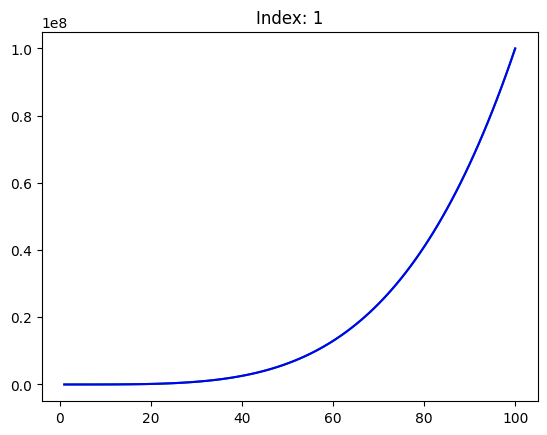

Index 5
Target:  (x * 5)
Best solution * x 5.00
Best fitness -0.00030000000000000003


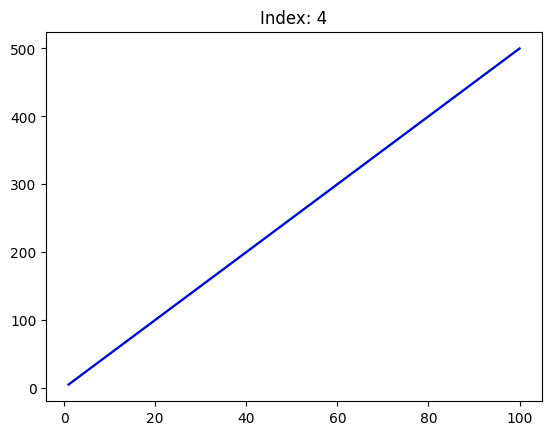

Index 8
Target:  ((x + 2) ** 9)
Best solution / - ^ + x + 6.00 9.00 9.00 ^ * 10.00 -12.00 8.00 3.00
Best fitness -2.9607226240072336e+34


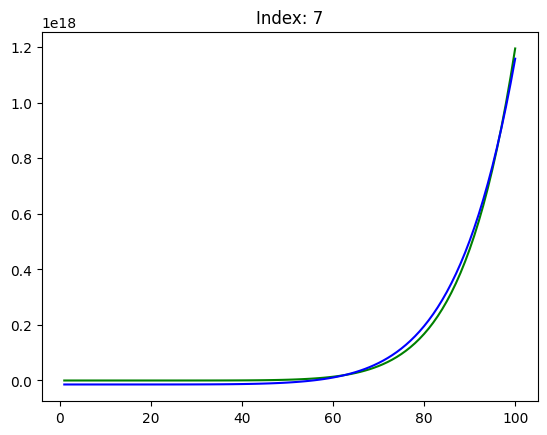

Index 9
Target:  (x * 2)
Best solution + x x
Best fitness -0.00030000000000000003


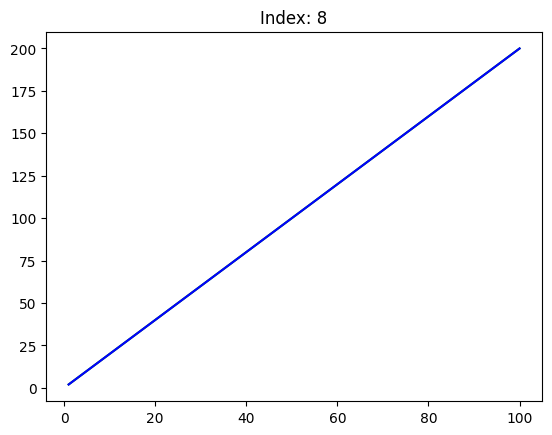

Index 14
Target:  (x ** 4)
Best solution + ^ x + 4.00 * 7.00 - / ^ * ^ -6.00 -4.00 10.00 / * / + ^ -6.00 4.00 9.00 -8.00 -6.00 4.00 / - + 0.00 0.00 + 3.00 -1.00 -7.00 ^ + ^ 7.00 6.00 -8.00 + 6.00 -10.00 ^ + - -4.00 10.00 + ^ * -4.00 0.00 x + -10.00 - ^ 4.00 * 9.00 1.00 x -9.00
Best fitness -0.006500000000000001


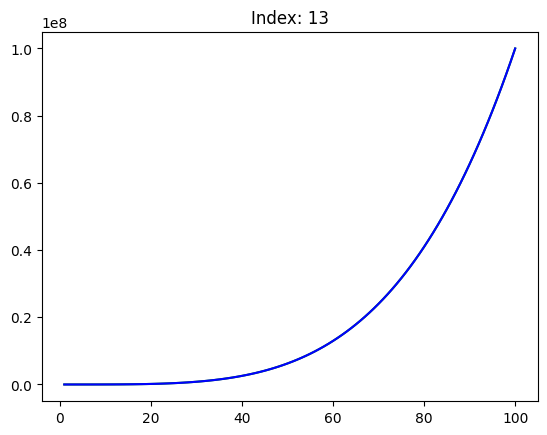

Index 23
Target:  ((x ** 1) ** 7)
Best solution ^ - x 0.00 7.00
Best fitness -0.0005


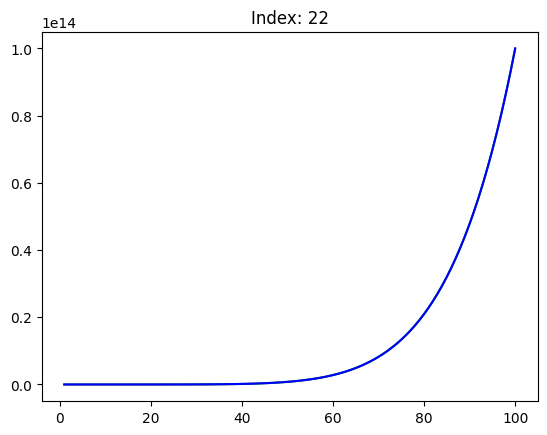

Index 26
Target:  (x - 7)
Best solution - x 7.00
Best fitness -0.00030000000000000003


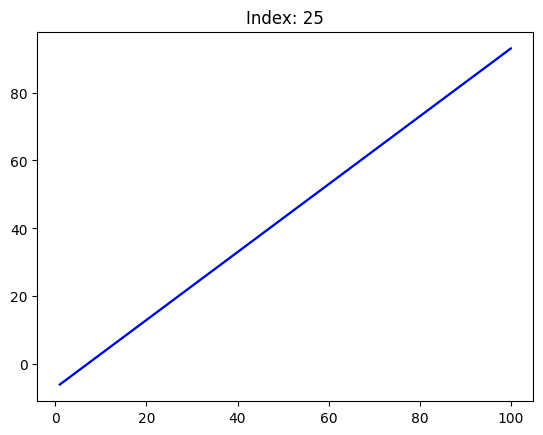

Index 30
Target:  (x + 6)
Best solution + x 6.00
Best fitness -0.00030000000000000003


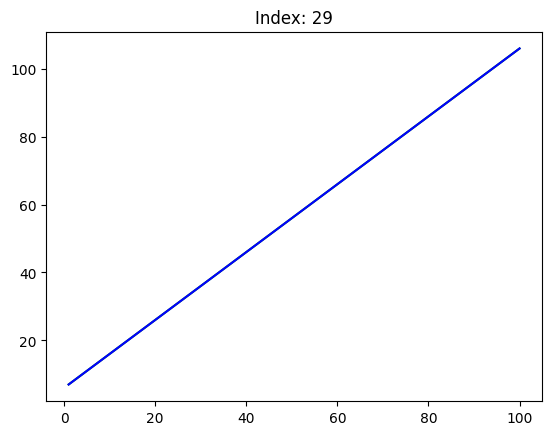

Index 34
Target:  ((x ** 9) ** 1)
Best solution ^ x - 7.00 -2.00
Best fitness -0.0005


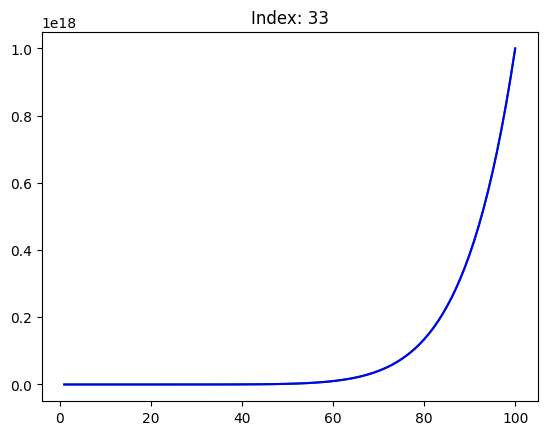

Index 39
Target:  (x / 2)
Best solution - + * 3.00 / x - * -2.00 / -10.00 -8.00 -9.00 -3.00 -5.00
Best fitness -123.78156656804734


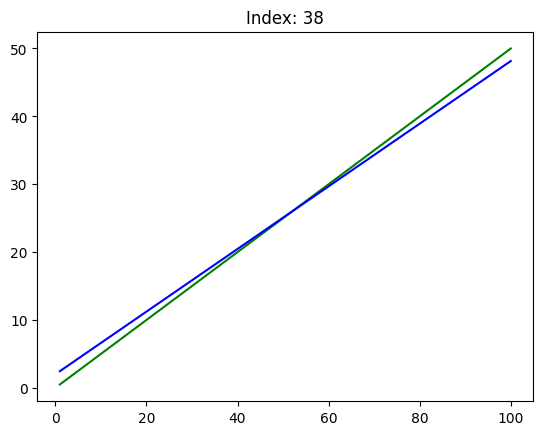

Index 46
Target:  (((x - 8) / x) / 6)
Best solution / + - x * -9.00 ^ 8.00 * / -1.00 ^ / * 4.00 3.00 x -3.00 3.00 -9.00 * x * - -6.00 * / ^ 8.00 3.00 * + 9.00 -6.00 * -8.00 * -5.00 4.00 -4.00 -4.00
Best fitness -0.011224395659635341


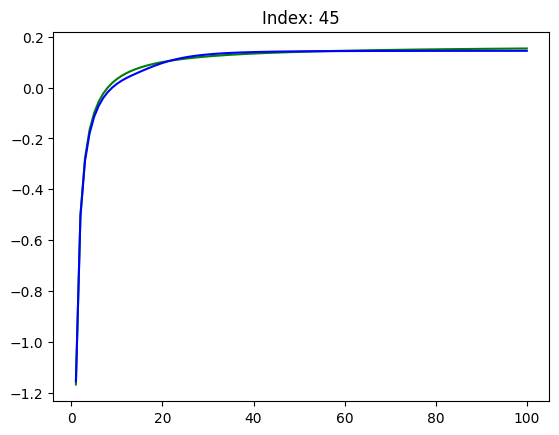

Index 50
Target:   1*x**2 + 4*x + 5
Best solution - x * - 0.00 x + 6.00 + x -3.00
Best fitness -2502.7511000000004


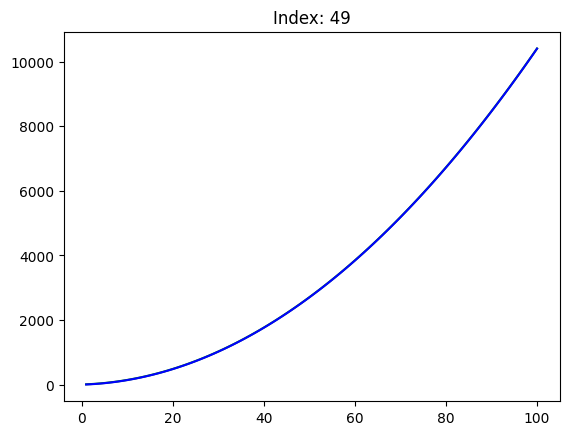

Index 52
Target:   -4*x**5 + -4*x + 5
Best solution - 2.00 * - ^ 9.00 / - ^ / 2.00 4.00 -3.00 - 9.00 -8.00 -5.00 * * + 10.00 -1.00 -8.00 6.00 * + ^ + + -1.00 x 3.00 * - / 0.00 ^ - + -10.00 -10.00 8.00 7.00 -3.00 ^ -7.00 - -2.00 + -9.00 7.00 -84.00 - + + -1.00 x / - 10.00 -3.00 - -3.00 9.00 - + / / 4.00 / 7.00 -2.00 -6.00 + 8.00 5.00 - -8.00 4.00
Best fitness -4.735605328601799e+19


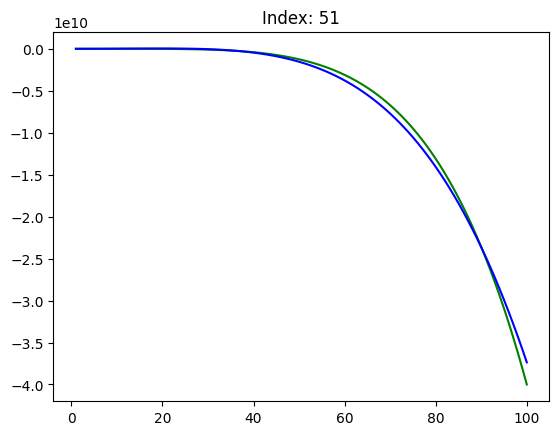

Index 57
Target:   4*x**2 + -2*x + +2
Best solution / - / * x x 6.00 - 10.00 -17.00 ^ -5.00 -2.00
Best fitness -31152399.152105525


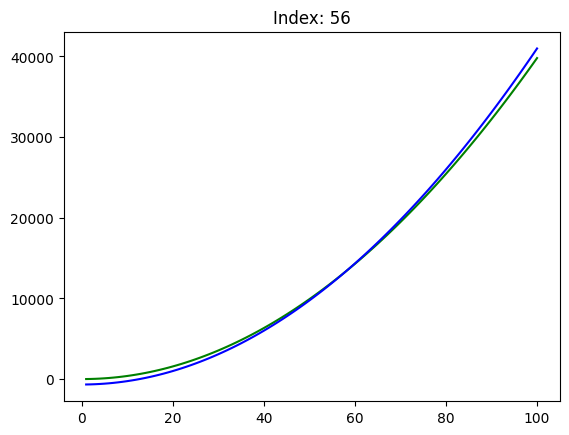

Index 61
Target:   1*x**4 + -2*x**3 + 2*x**2 + -1*x + +2
Best solution ^ x 4.00
Best fitness -57822631065033.45


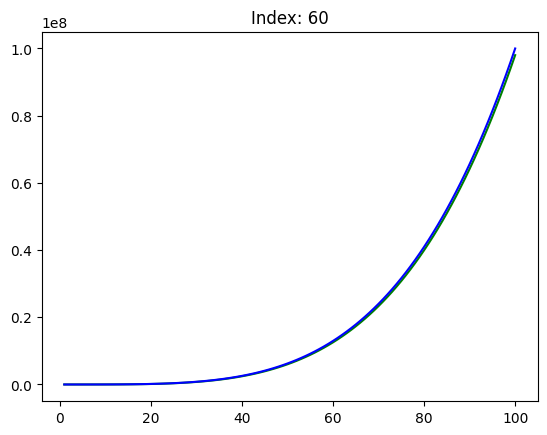

Index 68
Target:   -3*x**5 + 1*x**4 + 3*x**2 + 2*x + -1
Best solution / * / ^ - - 5.00 ^ 1.00 / 0.00 8.00 + 2.00 x * -4.00 -1.00 / -1.00 -3.00 ^ -10.00 * + -2.00 ^ -1.00 2.00 -3.00 / + / ^ * -6.00 * / x -5.00 10.00 * + 1.00 x 0.00 + 8.00 * ^ -4.00 0.00 / - -8.00 -9.00 -8.00 10.00 ^ - ^ 6.00 * 2.00 3.00 / * * 6.00 / ^ -4.00 -1.00 2.00 7.00 -6.00 0.00
Best fitness -6.886890281869526e+19


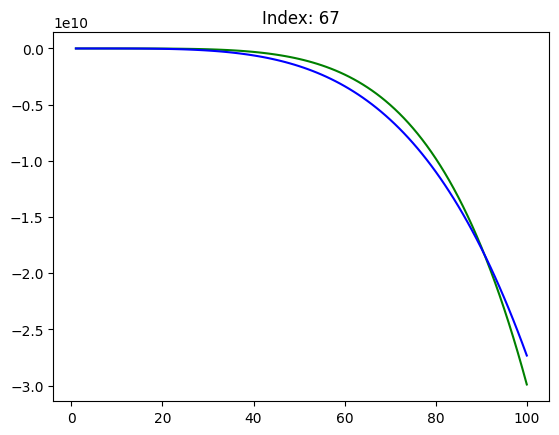

Index 70
Target:   -3*x**2 + 4*x + -3
Best solution * + * * / -11.00 - - 0.00 2.00 6.00 -5.00 + -1.00 * x / x 7.00 - 4.00 + + 3.00 ^ - * 9.00 -3.00 -1.00 -1.00 2.00 3.00
Best fitness -326258.49296419614


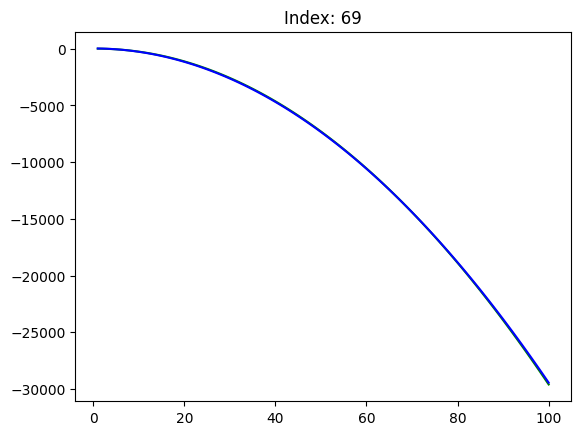

Index 71
Target:   1*x**5 + -1*x**4 + -2*x + +3
Best solution + + + ^ ^ - ^ + * -8.00 -2.00 -6.00 7.00 0.00 3.00 0.00 23.00 ^ x 5.00 * 26.00 * -26.00 * * + -15.00 -12.00 x -28.00
Best fitness -2.913228570195075e+16


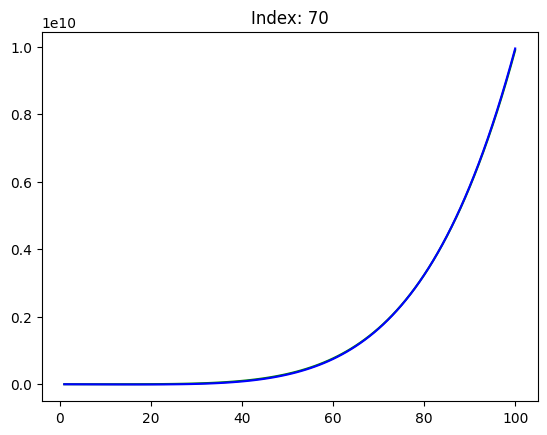

Index 74
Target:   -4*x**5 + 1*x**3 + 3*x + -3
Best solution + -98.00 / ^ - x / x - 10.00 + 9.00 6.00 5.00 / x / + / + - 9.00 * 6.00 -2.00 -5.00 1.00 * x -5.00 3.00
Best fitness -2.083723007070679e+17


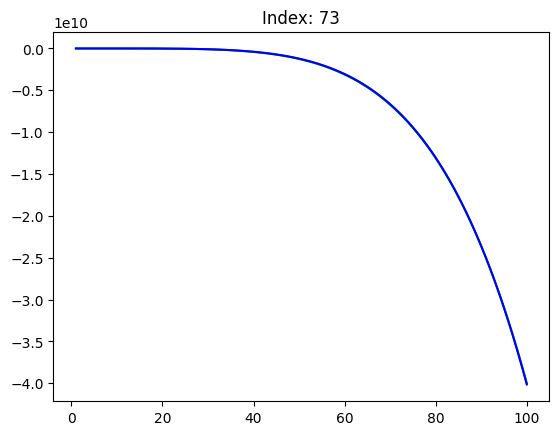

Index 78
Target:   1*x**5 + -1*x**4 + 1*x**3 + -1*x**2 + 2*x + -4
Best solution ^ x 5.00
Best fitness -1.1365406074006907e+17


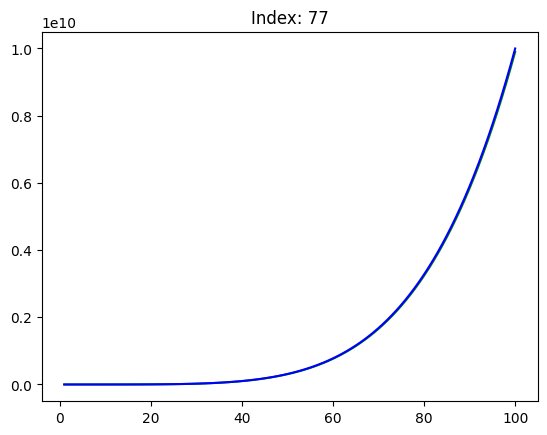

Index 84
Target:   1*x**4 + -4*x**3 + -1*x + -3
Best solution ^ x 4.00
Best fitness -236739441533290.28


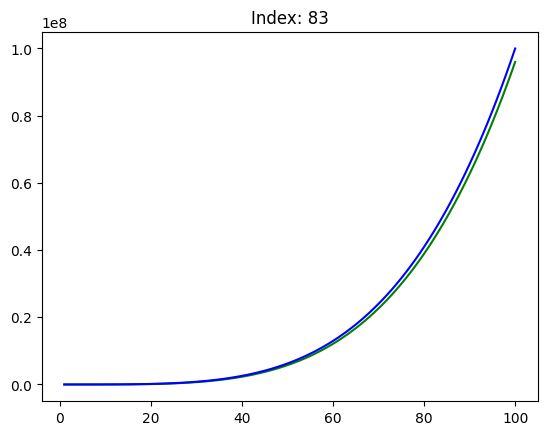

Index 86
Target:   -2*x**2 + 1*x + -3
Best solution * x * -2.00 x
Best fitness -309104.4755


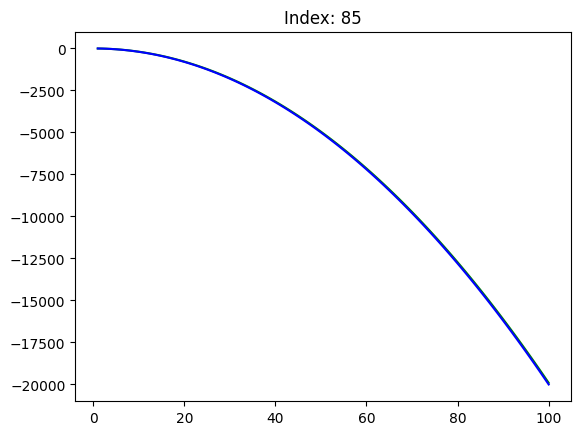

Index 87
Target:   3*x**5 + 1*x**4 + 2*x + +2
Best solution + / 2.00 ^ 7.00 -9.00 + ^ * * - + 7.00 8.00 x / / 2.00 / -1.00 - * - -8.00 -4.00 / + 5.00 6.00 10.00 -1.00 -7.00 5.00 4.00 100.00
Best fitness -3.6960080214391117e+18


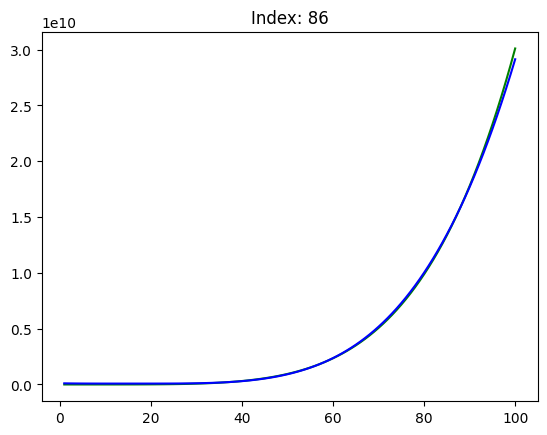

Index 89
Target:   -1*x**3 + -2*x + -1
Best solution - / - * + -9.00 ^ -2.00 -1.00 - -6.00 * ^ -6.00 + 3.00 -4.00 ^ -3.00 5.00 2.00 -4.00 + ^ x 3.00 -8.00
Best fitness -334200.30437968747


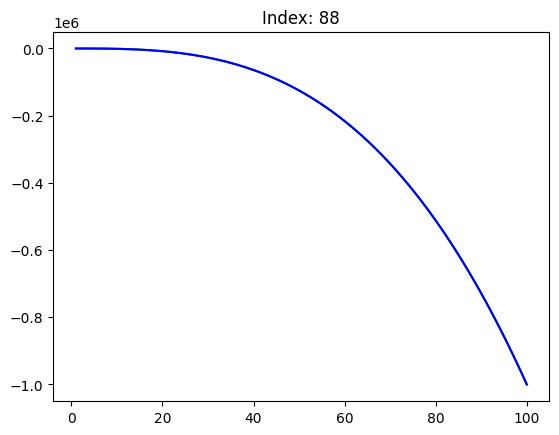

Index 93
Target:   4*x**5 + -1*x**4 + 1*x**3 + 4*x**2 + 3*x + -5
Best solution * - 8.00 4.00 ^ x 5.00
Best fitness -1.135529123145082e+17


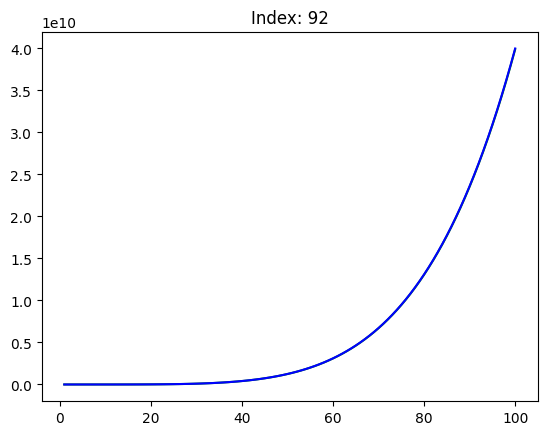

Index 96
Target:   3*x**5 + 2*x**4 + 1*x + -2
Best solution ^ + 0.00 - 4.00 / + 5.00 * x -5.00 ^ 1.00 / x * ^ x 1.00 -7.00 + / - -11.00 ^ 21.00 ^ - - ^ 4.00 2.00 10.00 4.00 -6.00 x 4.00
Best fitness -5.137592113507047e+18


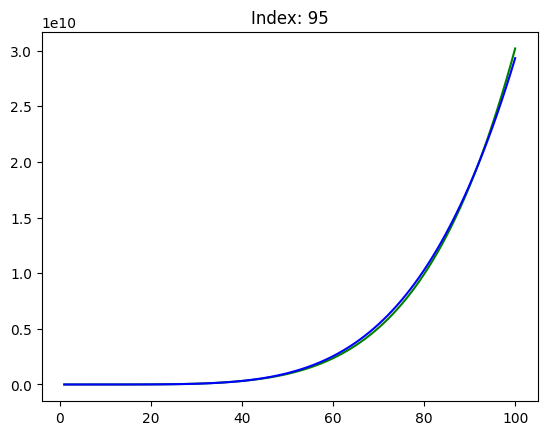

Index 98
Target:   4*x + +1
Best solution - * x 5.00 + -1.00 x
Best fitness -0.0007


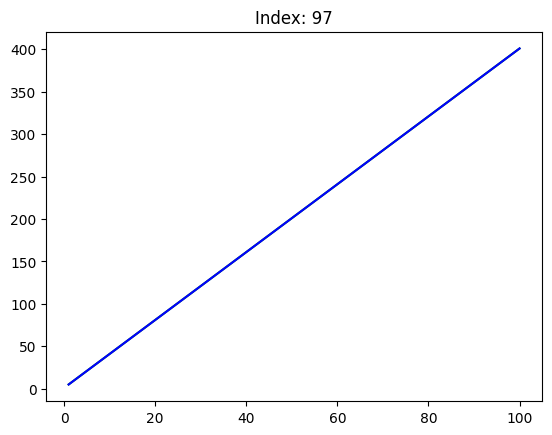

In [48]:
indices = list(range(0, 101))

indices = [1, 4, 7, 8, 13, 22, 25, 29, 33, 38, 45, 49, 51, 56, 60, 67, 69, 70, 73, 77, 83, 85, 86, 88, 92, 95, 97]
indices = [i + 1 for i in indices]

graph_predictions(best_models_filename='best_models_1.pkl', dataset_filename='dataset.csv', indices=indices)

## Extended mathematical operations 

### Custom dataset

We have created a custom dataset to confirm that the algorithm also identifies more diverse functions, such as trigonometric functions, logarithms, etc. 

In [59]:
dataset_file = "custom_dataset.csv"
best_models_file = "custom_models.pkl"

equation_indices = range(20)
skip_indices = []

train_params = {
    'mutation_probability': 1, 
    'keep_elitism': 10,
    'num_generations': 100
}

train_on_dataset(equation_indices, skip_indices, dataset_file, best_models_file, train_params, extra_operators=True)

processing 1
processing 2
processing 3
processing 4
processing 5
processing 6
processing 7
processing 8
processing 9


[(-0.0001, <__main__.Number at 0x124199e50>, 'name'),
 (-0.0002, <__main__.UnaryOperator at 0x1214214d0>, 'sin x'),
 (-0.0002, <__main__.UnaryOperator at 0x124128290>, 'cos x'),
 (-0.00020000372603535654, <__main__.UnaryOperator at 0x12172fc50>, 'exp x'),
 (-0.0002, <__main__.UnaryOperator at 0x124955610>, 'log x'),
 (-0.0002, <__main__.UnaryOperator at 0x1126f3ed0>, 'sqrt x'),
 (-0.0001, <__main__.X at 0x121bf99d0>, 'abs x'),
 (-0.0002, <__main__.UnaryOperator at 0x1215a4150>, 'neg x'),
 (-324.0990463119958,
  'log(x + 1) + exp(x)')]

Index 2
Target:  sin x
Best solution sin x
Best fitness -0.0002


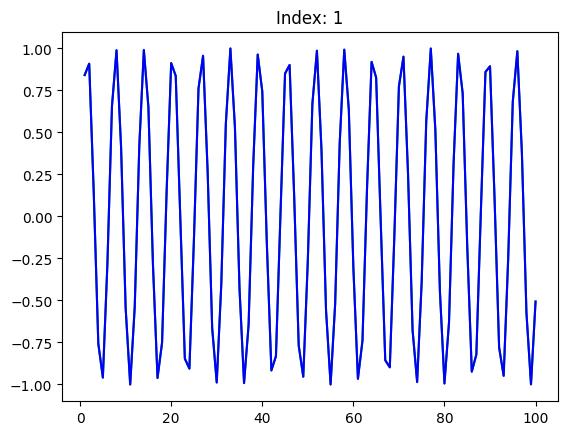

Index 3
Target:  cos x
Best solution cos x
Best fitness -0.0002


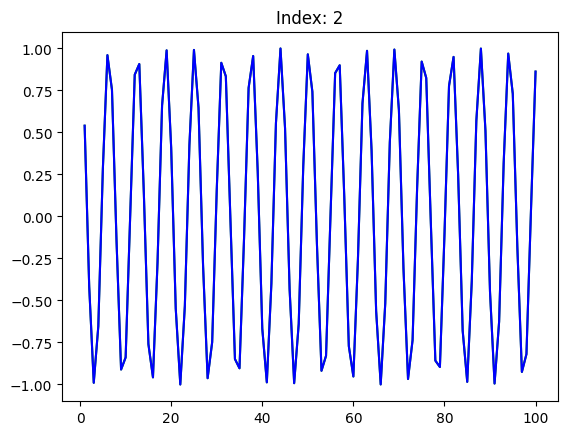

Index 4
Target:  exp x
Best solution exp x
Best fitness -0.00020000372603535654


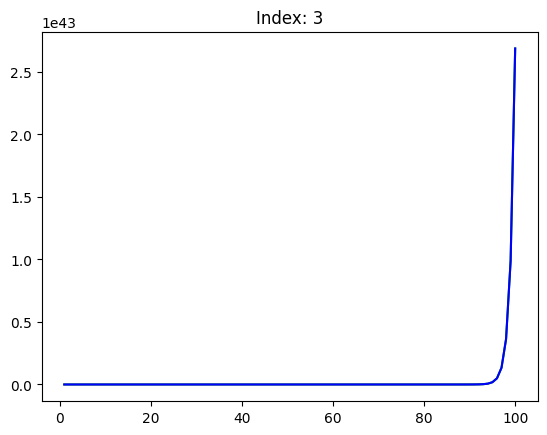

Index 5
Target:  log x
Best solution log x
Best fitness -0.0002


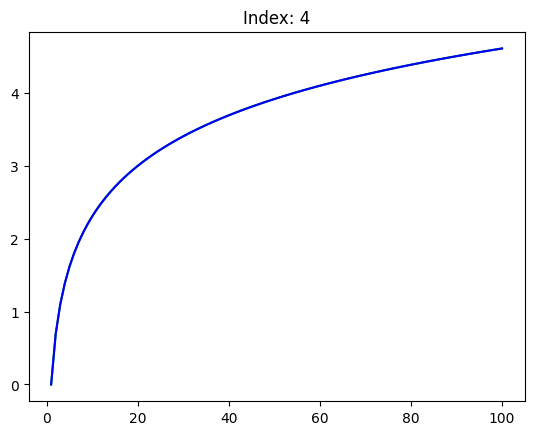

Index 6
Target:  sqrt x
Best solution sqrt x
Best fitness -0.0002


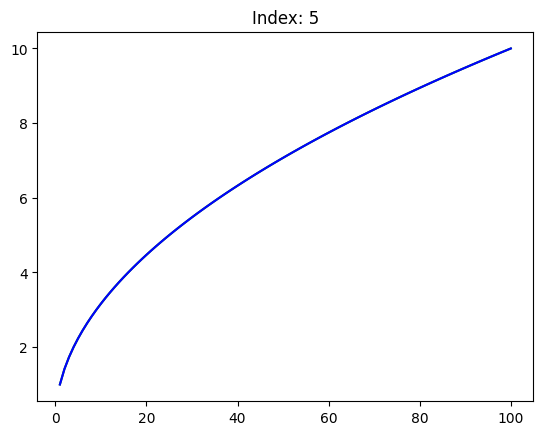

Index 7
Target:  abs x
Best solution x
Best fitness -0.0001


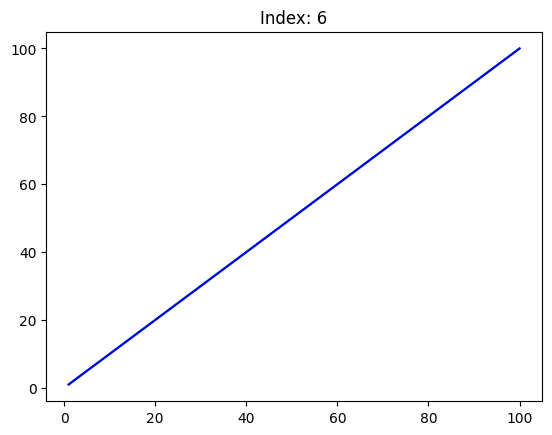

Index 8
Target:  neg x
Best solution neg x
Best fitness -0.0002


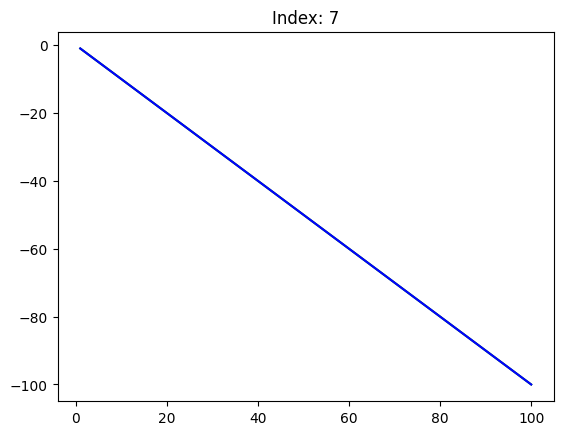

Index 9
Target:  log(x + 1) + exp(x)
Best solution + 3.00 exp abs x
Best fitness -21.51728753943446


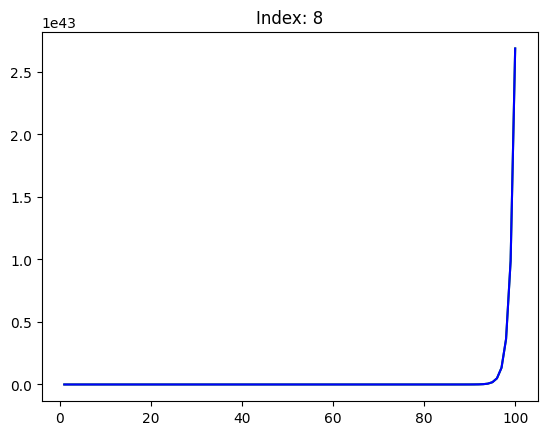

In [64]:
indices = range(2, 101)
# indices = [5, 6]

graph_predictions(best_models_filename='custom_models.pkl', dataset_filename='custom_dataset.csv', indices=indices)

## Genetic algorithm configurations

In [20]:
dataset_file = "dataset.csv"
best_models_file = "best_models_2.pkl"

equation_indices = [93]
skip_indices = []

train_params = {
    'mutation_probability': 1, 
    'keep_elitism': 10,
    'num_generations': 100
}

processing 99
processing 99
processing 99
processing 99
processing 99


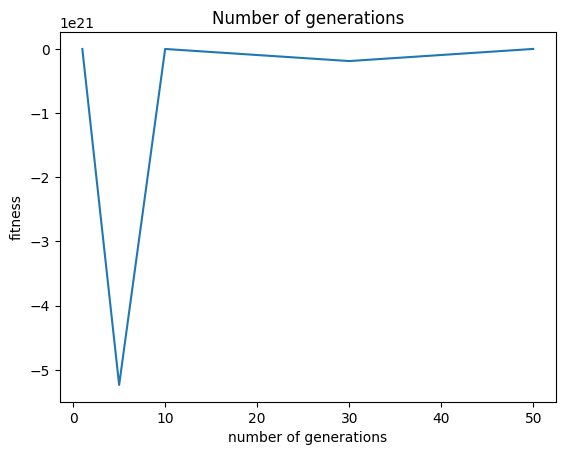

In [41]:
num_gen = [1, 5, 10, 30, 50]
fitness_for_n = []

for n in num_gen:
    train_params['num_generations'] = n
    res = train_on_dataset(equation_indices, skip_indices, dataset_file, best_models_file, train_params, extra_operators=False)
    fitness_for_n.append(res[0][0])


plt.title("Number of generations")
plt.xlabel('number of generations')
plt.ylabel('fitness')
plt.plot(num_gen, fitness_for_n)

processing 99
processing 99
processing 99
processing 99
processing 99


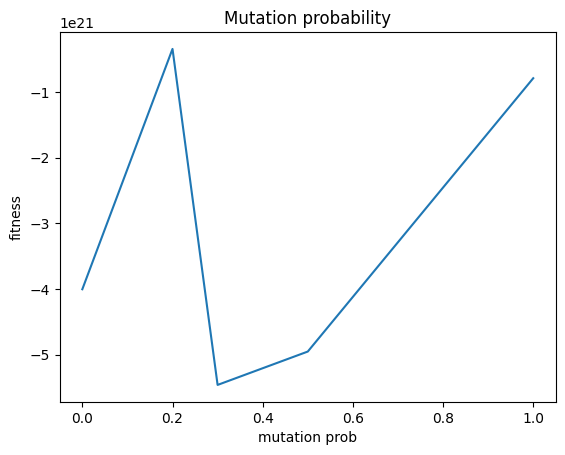

In [42]:
mutation_probabilities = [0, 0.2, 0.3, 0.5, 1]
fitness_for_n = []

for m in mutation_probabilities:
    train_params['mutation_probability'] = m
    res = train_on_dataset(equation_indices, skip_indices, dataset_file, best_models_file, train_params, extra_operators=False)
    fitness_for_n.append(res[0][0])

plt.title("Mutation probability")
plt.xlabel('mutation prob')
plt.ylabel('fitness')
plt.plot(mutation_probabilities, fitness_for_n)

processing 99
processing 99
processing 99
processing 99
processing 99


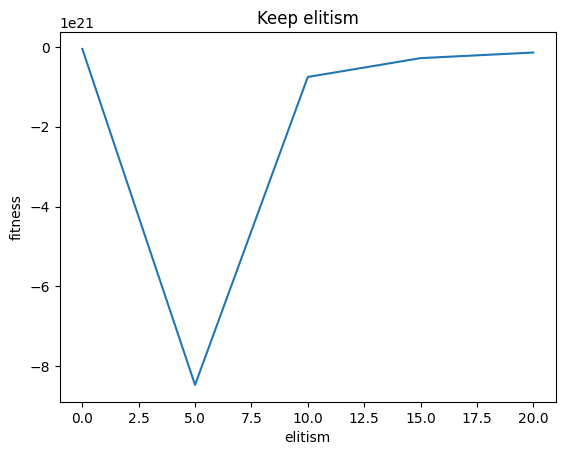

In [43]:
keep_elitism = [0, 5, 10, 15, 20]
fitness_for_n = []

for e in keep_elitism:
    train_params['keep_elitism'] = e
    res = train_on_dataset(equation_indices, skip_indices, dataset_file, best_models_file, train_params, extra_operators=False)
    fitness_for_n.append(res[0][0])

plt.title("Keep elitism")
plt.xlabel('elitism')
plt.ylabel('fitness')
plt.plot(keep_elitism, fitness_for_n)

## Time complexity

In [16]:
dataset_file = "dataset.csv"
best_models_file = "best_models_2.pkl"

equation_indices = []
skip_indices = []

train_params = {
    'mutation_probability': 1, 
    'keep_elitism': 10,
    'num_generations': 100
}

processing 1
processing 11
processing 25
processing 50
processing 99


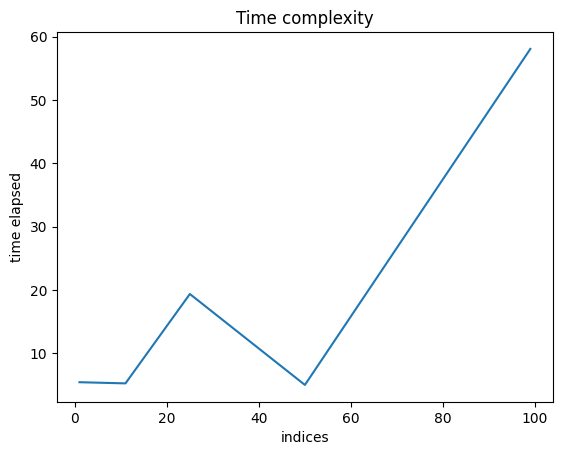

In [44]:
indices = [1, 11, 25, 50, 99]
time_elapsed = []

for i in indices:
    equation_indices = [i]
    skip_indices = []
    start = time.time()
    train_on_dataset(equation_indices, skip_indices, dataset_file, best_models_file, train_params, extra_operators=False)
    end = time.time()
    time_elapsed.append(end - start)

plt.title("Time complexity")
plt.xlabel('indices')
plt.ylabel('time elapsed')
plt.plot(indices, time_elapsed)